In [3]:
import numpy as np
import itertools
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from abc import ABC, abstractmethod
from typing import Any, Sequence, Tuple

In [4]:
COLORS = ((1, 0, 0),
          (0, 1, 0),
          (0, 0, 1),
          (1, 1, 0),
          (1, 0, 1),
          (0, 1, 1),
          (1, 1, 1),
          (.5, 0, 0),
          (0, .5, 0),
          (0, 0, .5))

class Mechanism(ABC):
    @abstractmethod
    def __call__(self, images: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        pass


class Colorize(Mechanism):
    def __init__(self, num_colors: int = 10):
        assert num_colors <= 10
        self.color_mapping = torch.zeros(10, 3)
        for label, color in zip(range(10), itertools.cycle(COLORS[:num_colors])):
            self.color_mapping[label] = torch.tensor(color)

    def __call__(self, image: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        return torch.cat([image] * 3, dim=0) * self.color_mapping[label].view(3, 1, 1)


class CounfoundedDataset(Dataset):
    def __init__(self, root: str, mechanisms: Sequence[Mechanism], train: bool = True, download: bool = False) -> None:
        self.base_dataset = torchvision.datasets.MNIST(root=root, train=train, download=download,
                                                       transform=transforms.ToTensor())
        self.mechanisms = mechanisms
        self.train = train

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image, label = self.base_dataset.__getitem__(index)
        for mechanism in self.mechanisms:
            image = mechanism(image, label if self.train else np.random.randint(0, 10))

        return image, label

    def __len__(self):
        return len(self.base_dataset)


In [5]:
path = './data/mnist/'

#img_size = [28, 28]
#trainset = torchvision.datasets.MNIST(path, train=True, download=False, transform=transforms.ToTensor())

img_size = [3, 28, 28]
trainset = CounfoundedDataset(path, mechanisms=[Colorize(10)], train=True, download=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)

In [6]:
data = []
for image, _ in trainloader:
    data.append(image.detach().numpy())
data = np.concatenate(data)
X = data.reshape(data.shape[0], np.prod(img_size))
X = X[:10000].T
m, n = X.shape
print('Dimension:\t' + str(m))
print('Samples:\t' + str(n))

Dimension:	2352
Samples:	10000


In [7]:
print(np.max(X))

1.0


In [8]:
import numpy as np
from sklearn import decomposition

pca = decomposition.PCA(whiten=False)

X_prime = pca.fit_transform(X.T).T
mu = pca.mean_
U = pca.components_.T
D = pca.singular_values_**2 / (n - 1)
exp_var = pca.explained_variance_ratio_

print('Size before PCA: ' + str(X.shape))
print('Size after PCA: ' + str(X_prime.shape))

print('Size of U: ' + str(U.shape))
print('Size of D: ' + str(D.shape))

Size before PCA: (2352, 10000)
Size after PCA: (2352, 10000)
Size of U: (2352, 2352)
Size of D: (2352,)


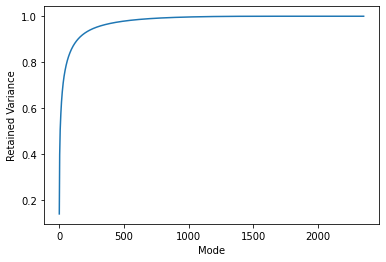

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.cumsum(exp_var))
ax.set_xlabel('Mode')
ax.set_ylabel('Retained Variance')
plt.show()    

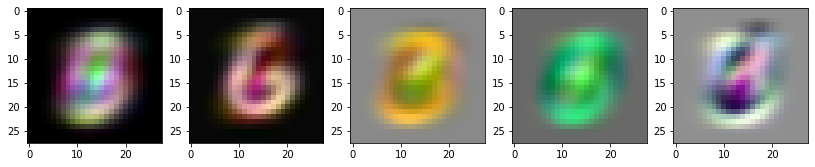

In [10]:
mu_img = mu
mode1 = U[:,0] * np.sqrt(D[0])*1;
mode2 = U[:,1] * np.sqrt(D[1])*1;
mode3 = U[:,2] * np.sqrt(D[2])*1;
mode4 = U[:,3] * np.sqrt(D[3])*1;

mu_img -= np.min(mu_img)
mode1 -= np.min(mode1)
mode2 -= np.min(mode2)
mode3 -= np.min(mode3)
mode4 -= np.min(mode4)

mu_img /= np.max(mu_img)
mode1 /= np.max(mode1)
mode2 /= np.max(mode2)
mode3 /= np.max(mode3)
mode4 /= np.max(mode4)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(14, 4))
ax1.imshow(mu_img.reshape(img_size).transpose(1, 2, 0))
ax2.imshow(mode1.reshape(img_size).transpose(1, 2, 0))
ax3.imshow(mode2.reshape(img_size).transpose(1, 2, 0))
ax4.imshow(mode3.reshape(img_size).transpose(1, 2, 0))
ax5.imshow(mode4.reshape(img_size).transpose(1, 2, 0))
plt.show()

In [11]:
from ipywidgets import interact, fixed

def plot_digit(mean_shape,modes,s1,s2,s3,s4):
    image = mu + U[:,0] * s1 + U[:,1] * s2 + U[:,2] * s3 + U[:,3] * s4
    image -= np.min(image)
    image /= np.max(image)
    plt.imshow(image.reshape(img_size).transpose(1, 2, 0))

def interactive_pca(mu,U,D):
    interact(plot_digit,mean_shape=fixed(mu),modes=fixed(U),
             **{'s%d' % (i+1): (-np.sqrt(D[i]) * 6, np.sqrt(D[i]) * 6, np.sqrt(D[i])) for i in range(4)});

interactive_pca(mu,U,D)

interactive(children=(FloatSlider(value=0.0, description='s1', max=21.138060092926025, min=-21.138060092926025…